In [110]:
%matplotlib inline

import math
import random

from scipy.stats import norm, binom, beta
from matplotlib import pyplot as plt

The normal distribution can be used as an approximation to the binomial distribution, under certain circumstances, namely:

If X ~ B(n, p) and if n is large and/or p is close to ½, then X is approximately N(np, npq)
(where q = 1 - p).

In [10]:
def normal_approximation_to_binomial(n, p):
    """Finds mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n) # Why is there a square root here?
    return mu, sigma

In [65]:
normal_approximation_to_binomial(20, 0.5), binom.stats(20, 0.5), math.sqrt(5)

((10.0, 2.23606797749979), (array(10.), array(5.)), 2.23606797749979)

In [12]:
# Same as norm.cdf.

def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

In [13]:
# Same as norm.ppf(p, mu, sigma).

def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """Find approximate inverse using binary search"""
    # If not standard, compute standard and rescale.
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    lo_z, lo_p = -10.0, 0
    hi_z, hi_p = 10.0, 1
    while hi_z - lo_z > tolerance:
        mid_z = (lo_z + hi_z) / 2
        mid_p = normal_cdf(mid_z)
        if mid_p < p:
            # Midpoint is still too low, search above it.
            lo_z, lo_p = mid_z, mid_p
        elif mid_p > p:
            # Midpoint is still too high, search below it.
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z

In [14]:
# The normal cdf is the probability the variable is below the threshold.
normal_probability_below = normal_cdf

# It's above the threshold id it's not below the threshold.
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

In [15]:
# It's between if it's less than hi, but not less than lo.
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

In [16]:
# It's outside if it's not between.
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [17]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """Returns the z for which P(Z <= z) = probability."""
    return inverse_normal_cdf(probability, mu, sigma)

In [60]:
normal_upper_bound(0.1), norm.ppf(0.1) # ppf stands for percent point function, another name for quantile function.

(-1.2815570831298828, -1.2815515655446004)

In [19]:
def normal_lower_bound(probability, mu=0, sigma=1):
    """Returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

In [20]:
def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """Returns the symmetric (about the mean) bounds that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    
    # Upper bound should have tail_probability above it.
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    
    # Lower bound should have tail_probability below is.
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    
    return lower_bound, upper_bound

In [98]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
mu_0, sigma_0

(500.0, 15.811388300841896)

In [107]:
# 95% bounds based on assumption p is 0.5.
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
lo, hi

(469.01026640487555, 530.9897335951244)

In [100]:
# Actual mu and sigma based on p = 0.55.
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

In [87]:
# A type 2 error means we fail to reject the null hypothesis which will
# happen when X is still in out original interval.
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability
power

0.8865480012953671

In [88]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
hi

526.0073585242053

In [89]:
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability
power

0.9363794803307173

In [102]:
# Examples with scipy.
mu_0, sigma_0 = binom.stats(1000, 0.5)
sigma_0 = math.sqrt(sigma_0)
mu_0, sigma_0

(array(500.), 15.811388300841896)

In [109]:
norm.ppf((1 - 0.95) / 2, mu_0, sigma_0), norm.ppf(1 - ((1 - 0.95) / 2), mu_0, sigma_0)

(469.0102483847719, 530.9897516152281)

In [27]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # If x is greater than the mean, the tail is what's greater than x.
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # If x is less than the mean, the tail is what's less than x.
        return 2 * normal_probability_below(x, mu, sigma)

In [28]:
two_sided_p_value(529.5, mu_0, sigma_0)

0.06207721579598835

In [29]:
extreme_value_count = 0
for _ in range(10000):
    num_heads = sum(1 if random.random() < 0.5 else 0
                    for _ in range(1000))
    if num_heads >= 530 or num_heads <= 470:
        extreme_value_count += 1
extreme_value_count / 10000

0.0614

In [30]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [31]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [32]:
upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582072

In [33]:
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

In [34]:
## Confidence interval

In [35]:
# math.sqrt(p * (1-p) / 1000)
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
sigma

0.015791611697353755

In [36]:
normal_two_sided_bounds(0.95, mu, sigma)

(0.4940490278129096, 0.5559509721870904)

In [37]:
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
normal_two_sided_bounds(0.95, mu, sigma)

(0.5091095927295919, 0.5708904072704082)

In [38]:
## P-hacking

In [39]:
def run_experiment():
    """Flip a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

In [40]:
def reject_fairness(experiment):
    """Using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

In [41]:
random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                      for experiment in experiments
                      if reject_fairness(experiment)])

In [42]:
num_rejections

46

In [43]:
## Running an A/B test

In [44]:
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [45]:
def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [46]:
# If "tastes great" gets 200 clicks from 1000 views, and "less bias" gets 180 clicks out of 1000 views...
z = a_b_test_statistic(1000, 200, 1000, 180)
z

-1.1403464899034472

In [47]:
two_sided_p_value(z)

0.254141976542236

In [48]:
# On the other hand, if "less bias" gets only 150 clicks.
z = a_b_test_statistic(1000, 200, 1000, 150)
two_sided_p_value(z) # Which means that there's only 0.003 probability that you will see such a large difference if the ads are equally effective.

0.003189699706216853

In [49]:
# Bayesian Inference

In [50]:
def B(alpha, beta):
    """A normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

In [51]:
def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1:
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

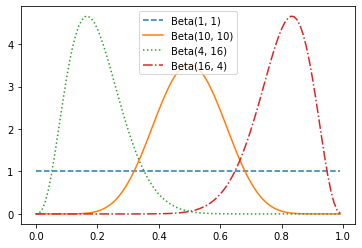

In [67]:
X = [i / 100 for i in range(100)]
plt.plot(X, [beta_pdf(x, 1, 1) for x in X], '--', label='Beta(1, 1)')
plt.plot(X, [beta_pdf(x, 10, 10) for x in X], '-', label='Beta(10, 10)')
plt.plot(X, [beta_pdf(x, 4, 16) for x in X], ':', label='Beta(4, 16)')
plt.plot(X, [beta_pdf(x, 16, 4) for x in X], '-.', label='Beta(16, 4)')
plt.legend(loc=9)

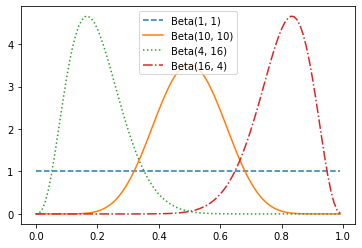

In [69]:
X = [i / 100 for i in range(100)]
plt.plot(X, [beta.pdf(x, 1, 1) for x in X], '--', label='Beta(1, 1)')
plt.plot(X, [beta.pdf(x, 10, 10) for x in X], '-', label='Beta(10, 10)')
plt.plot(X, [beta.pdf(x, 4, 16) for x in X], ':', label='Beta(4, 16)')
plt.plot(X, [beta.pdf(x, 16, 4) for x in X], '-.', label='Beta(16, 4)')
plt.legend(loc=9)